In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

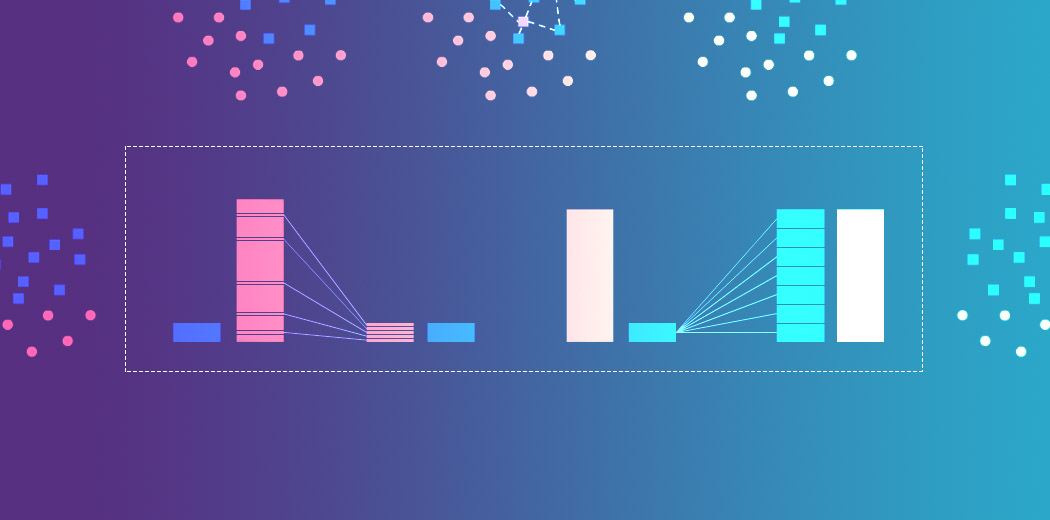

# Giriş
Dengesiz veriseti sınıflandırılacak sınıflardan birinin diğerine oranla yetersiz olması durumunda model performasını doğrudan etkileyen problemlerden birisidir.

Bu çalışmada dengesiz veri setinde oversampling yöntemlerini ve etkileri gözlemlenecektir. 
Çalışmanın özeti şöyledir:

* 1-Importing
* 2-EDA
* 3-Feature Engineering
* 4-Model ve Skorlama
* 5-OverSampling Yöntemleri
* * 5.1. Random OverSampling
* * 5.2. SMOTE OverSampling
* * 5.1. Borderline SMOTE 
* * 5.1. Bordelerline-SMOTE SVM 
* * 5.1. Adaptive Synthetic Sampling (ADASYN)



# 1-Importing


In [ ]:
#Gerekli kütüphaneler ortama yükleniyor.

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from imblearn.over_sampling import RandomOverSampler,SMOTE,BorderlineSMOTE,SVMSMOTE,ADASYN
from sklearn.decomposition import PCA
from numpy import where
from collections import Counter
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")



In [ ]:
# Gerekli fonksiyonlar ortama yükleniyor.

def control_df(df,cat=10):
    print("###############################################################")
    print("İlk 5 veri")
    print(df.head())
    print("###############################################################")
    print("Verinin boyutları:")
    print(df.shape)
    print("###############################################################")
    print("Verideki boş gözlem sayısı:")
    print(df.isnull().sum())
    cat_cols = [col for col in df.columns if df[col].dtype == "O"]
    num_but_cat_cols = [col for col in df.columns if df[col].nunique() < cat and df[col].dtype != "O"]
    cat_but_num_cols = [col for col in df.columns if df[col].nunique() > 20 and df[col].dtype == "O"]
    cat_cols = cat_cols + num_but_cat_cols
    num_cols = [col for col in df.columns if col not in cat_cols]
    print("###############################################################")
    print("Verideki kategorik değişkenler")
    print(cat_cols)
    print("###############################################################")
    print("Verideki sayısal değişkenler")
    print(num_cols)

    return cat_cols, num_cols

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
        

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def gg2(df, target,col_names):
    """
    Verilen col_names için target'a göre ortalamasının grafiğini çizer.
    :param df:
    :param target:
    :param col_names:
    :return:
    """
    col_names = col_names
    # col_names=df.columns[~df.columns.str.contains("charges")]
    print(col_names)
    for col in col_names:
        ss = df.groupby(col)[target].mean()
        plt.ylabel(target)
        plt.title(f"{col} adlı değişken kırılımında ortalama")
        plt.legend()
        # sns.set(rc={'figure.figsize': (8, 10)})
        sns.barplot(x=ss.index, y=ss.values)
        plt.show()
        print("\n")
        print(ss)
        print("######################\n\n")        

def plot_confusion_matrix(y, y_pred):
    from sklearn.metrics import accuracy_score
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()


def scoring(model, x_train, y_train, x_test, y_test):


    y_prob = model.predict_proba(x_test)[:, 1]
    y_pred = model.predict(x_test)

    plot_confusion_matrix(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    ss={"ACCURACY SCORE" : accuracy_score(y_test, y_pred),
        "PRECISION SCORE" : (cm[0, 0]) / (cm[0, 1] + cm[0, 0]),
        "RECALL SCORE" : recall_score(y_test, y_pred),
        "F1 SCORE" : f1_score(y_test, y_pred),
        "AUC SCORE" : roc_auc_score(y_test, y_prob)}
    print(ss)
    return ss

def pca_plot(x,y):
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(x)
    counter = Counter(y)
    for label, _ in counter.items():
        row_ix = where(y == label)[0]
        pyplot.scatter(pca_fit[row_ix, 0], pca_fit[row_ix, 1], label=str(label))
    pyplot.legend()
    pyplot.show()

In [ ]:
# Veri seti yükleniyor

df=pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")

# 2-EDA

Veri seti ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 
yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması 
için kullanılan verileri içeriyor.

Veri setinde 768 örnek 8 değişken vardır.Bu değikşenler:

* Pregnancies – Hamilelik sayısı
* Glucose – Glikoz değeri
* Blood Pressure – Kan Basıncı (Küçük tansiyon) (mm Hg)
* SkinThickness – Cilt Kalınlığı
* Insulin – 2 saatlik serum insülini (mu U/ml)
* DiabetesPedigreeFunction - 
* Age – Yaş (yıl)
* Outcome: Hastalığa sahip (1) ya da değil (0)

In [ ]:
#0 sınıfına ait 500 örnek var iken 1 sınıfına ait 268 örnek var.
#Bu dengesiz dağılımı gidermek için kullanılan yöntemlerden bazıları üzerinde duracağız.

df["Outcome"].value_counts()

In [ ]:
#Veri setinin genel özellikleri
#kategorik verilerin ve nümerik verilerin değişkenlere atanması

cat_cols,num_cols=control_df(df,18)

In [ ]:
#Kategorik değişkenleri anlama,diğer değişkenler ile ilişkisi

for col in cat_cols:
    cat_summary(df,col,True)


In [ ]:
#Aykırı değer tespiti ve baskılama yöntemi ile giderilmesi

for col in num_cols:
    replace_with_thresholds(df,col)

In [ ]:
#Outcome değişken kırılımında değişkenlerin ortalama değerleri

df.groupby("Outcome").mean().T



# 3-Feature Engineering

Diyabet hastalığı hakkında ufak bir literatür çalışması ya da değişkenlere istatiksel bir bakış açısıyla yaklaşılarak feature engineering kısmı çok daha zenginleştirilebilir.Ancak bu çalışmada asıl amaç bu olmadığı için üzerinde fazla durmayacağım.
Sadece önemli olduğunu düşündüğüm bir kaç küçük değişken eklemesi yapacağım.

In [ ]:
# Insülin değeri yetersiz mi? 
# BMI değeri yüksek mi?

df["Is_Insufficent_Insulin"] = ["1" if val <126 else "0" for val in df["Insulin"]]

df["Is_BMI_Over"] = ["1" if val >30 else "0" for val in df["BMI"]]

In [ ]:
#Scaling
for col in num_cols:
    ss = df[col].values.reshape(-1,1)
    transformer= MinMaxScaler().fit(ss)
    df[col] = transformer.transform(ss)

In [ ]:
#Encoding
df["Pregnancies"] = df["Pregnancies"].astype("O")
df.info()
df = pd.get_dummies(df,drop_first=True)

# 4-Model ve Skorlama
Dengesiz veri seti ile çalışırken en önemli karar noktalarından birisi skorlamak için seçtiğimiz metriktir.
Bu yüzden Accuracy,Recall,Precision,F1 Score,Auc skorlarını kendi önem sıranıza göre değerlendirmelisiniz.

In [ ]:

y=df["Outcome"]
x=df.drop(["Outcome"],axis=1)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
log_model = LogisticRegression().fit(x_train, y_train)
scores=scoring(log_model,x_train,y_train,x_test,y_test)
pca_plot(x_train,y_train)

# 5-OverSampling Yöntemleri

Dengesiz veri setiyle başa çıkmada en yaygın kullanılan yöntemlerden birisidir.
Azınlık olan sınıfa yeni örnekler ekleyerek dengeli bir dağılım oluşturmayı hedefler.
Bu çalışmada farklı varyasyonlarını inceleyip PCA ile 2 boyuta indirgeyip görselleştirmesini gösterilecek.

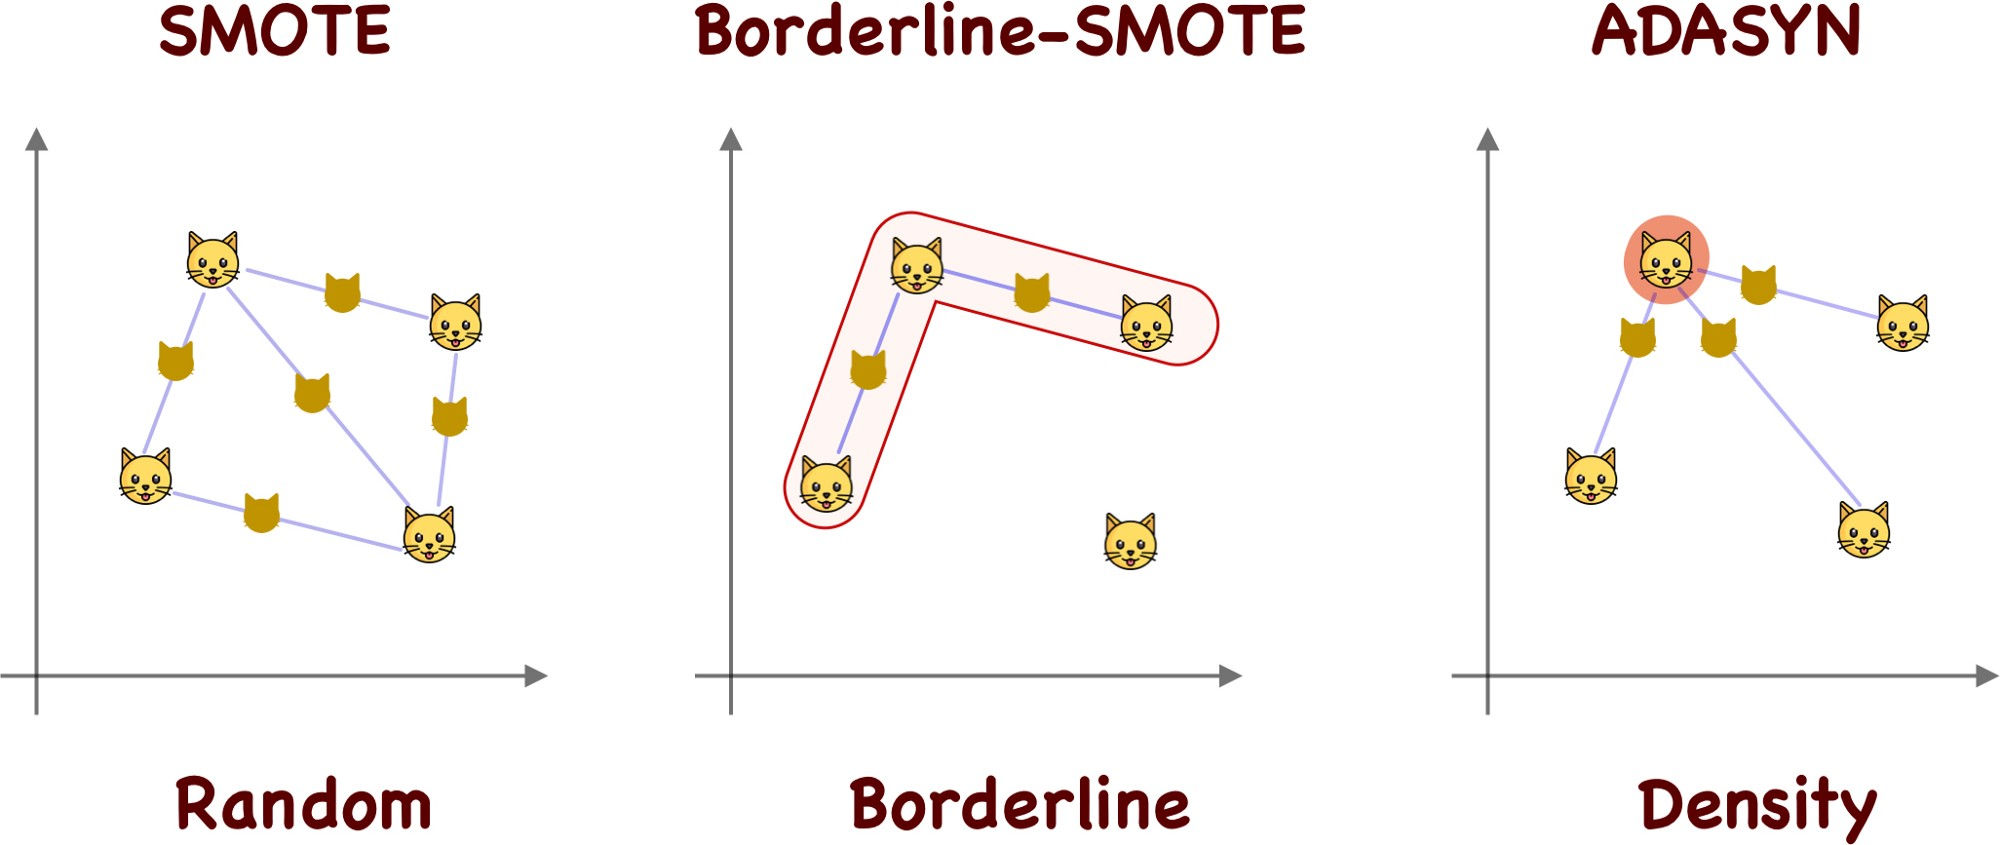


## 5.1.Random Oversampling

* Azınlık sınıfından rastgele örneklerin verisetine yeniden eklenmesi ile oluşur.
* Rastgele örnekler kopyalanarak elde edildiğinden duplicate örnekler oluşur.
* Büyük oranlarda yapılması gerekirse veriler tekrar edeceğinden dolayı genellemeyi ortadan kalıdırıp,ezbere yol açabilir.

In [ ]:
oversample=RandomOverSampler(sampling_strategy="minority")
x_randomover,y_randomover = oversample.fit_resample(x_train,y_train)
y_randomover.value_counts()
log_model.fit(x_randomover,y_randomover)
random_scores=scoring(log_model,x_randomover,y_randomover,x_test,y_test)
pca_plot(x_randomover,y_randomover)


## 5.2.SMOTE Oversampling
* Veri setinden rastgele örneklerin kopyalanması yerine o örneklere benzer sentetik örnekler üretilmesini amaçlar.
* Veri setinden rastgele olarak bir örnek seçilir.Daha sonra bu örneğin en yakın komşularından k tanesi (default=5) belirlenir.
* Bu komşular arasından bir tanesi rastgele seçilir ve bu iki örnek arasından rasgtele olarak seçilen bir noktada sentetik örnek oluşturulur.


In [ ]:
oversample=SMOTE()
x_smote,y_smote = oversample.fit_resample(x_train,y_train)
y_smote.value_counts()
log_model.fit(x_smote,y_smote)
smote_scores=scoring(log_model,x_smote,y_smote,x_test,y_test)
pca_plot(x_smote,y_smote)

## 5.3.BorderlineSMOTE

* Klasik SMOTE yaklaşımındaki rastgele örnekler üretmek yerine iki sınıf arasındaki karar sınırına yakın yerlerde örnekler üretir.


In [ ]:
oversample = BorderlineSMOTE()
x_border,y_border = oversample.fit_resample(x_train,y_train)
y_border.value_counts()
log_model.fit(x_border,y_border)
border_scores = scoring(log_model,x_border,y_border,x_test,y_test)
pca_plot(x_border,y_border)

## 5.4.Borderline-SMOTE SVM
* Borderline SMOTE yaklaşımından farkı karar sınırını belirlerken KNN yerine SVM algoritmasını kullanmasıdır
* Buna ek olarak azınlık sınıfının örneklerinin az olduğu bölgelerden örnek üretmeye çalışır.

In [ ]:
oversample=BorderlineSMOTE()
x_svm,y_svm = oversample.fit_resample(x_train,y_train)
y_svm.value_counts()
log_model.fit(x_svm,y_svm)
svm_scores = scoring(log_model,x_svm,y_svm,x_test,y_test)
pca_plot(x_svm,y_svm)


## 5.5 Adaptive Synthetic Sampling (ADASYN)
* Temel olarak sınıfların örnek yoğunluğuna göre bölgesel olarak örnek üretmeye çalışır.

In [ ]:
oversample=ADASYN()
x_ada,y_ada = oversample.fit_resample(x_train,y_train)
y_ada.value_counts()
log_model.fit(x_ada,y_ada)
ada_scores = scoring(log_model,x_ada,y_ada,x_test,y_test)
pca_plot(x_ada,y_ada)